In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

df=pd.read_csv("/content/drive/MyDrive/Deeplearning/Final Project/Reviews.csv", encoding='latin-1', index_col=0)
df=df.loc[:,["Text","Score"]].dropna().reset_index(drop=True)

In [3]:
len(df)

568454

In [4]:
df.loc[df['Score'] <=2, 'Score'] = -1
df.loc[df['Score'] > 3, 'Score'] = 1
df.loc[df['Score'] == 3, 'Score'] = 0
df['len'] = df.Text.apply(lambda x: len(x.split()))
df = df[df.len<50]

In [5]:
import re
df['Text']=df['Text'].apply(lambda row : re.sub('<.*?>','',row))

In [6]:
df["Score"].value_counts()

 1    203802
-1     30286
 0     14346
Name: Score, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
rev=df["Text"]
target=df["Score"]
x_train, x_test, y_train, y_test = train_test_split(rev,target,test_size=0.1,random_state=0,stratify=target)


In [11]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 80
batch_size = 32

#Tokenizing
tokenizer=Tokenizer(max_features,oov_token="<?>")
tokenizer.fit_on_texts(x_train)
X_train=tokenizer.texts_to_sequences(x_train)

word_index = tokenizer.word_index # This part is important for pre-trained embedding
print('Found %s unique tokens.' % len(word_index))

X_test=tokenizer.texts_to_sequences(x_test)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

# X_train with upper case "X" is tokenized, x_train with lower case "x" is not

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
print('Pad sequences (samples x text length)')
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Found 52121 unique tokens.
223590 train sequences
24844 test sequences
Pad sequences (samples x text length)
X_train shape: (223590, 80)
X_test shape: (24844, 80)


In [12]:
# Optional code for glove download
import requests  
import os  
file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
    
r = requests.get(file_url, stream = True)  

if not os.path.exists("glove.6B.zip"):
  print("Downloading...")
  with open("glove.6B.zip", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
      if block:  
        file.write(block)  
else:
  print("Archive file already existed. Delete the original zip file if you want to re-download")


print("Uncompressing...")
!unzip 'glove.6B.zip'

Downloading...
Uncompressing...
Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [13]:
import os
glove_dir = '/content/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [14]:
embedding_dim = 100 #This value should match the number before "d.txt", which means that it has to be 100 if the glove embedding is 100d.txt

embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_features:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.layers import Embedding

model = Sequential()
model.add(layers.Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(layers.GRU(64,dropout=0.2,recurrent_dropout=0.2))
model.add(layers.Dense(1))

# we are adding our pretrained weights from glove here. 
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 100)           1000000   
                                                                 
 gru (GRU)                   (None, 64)                31872     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,031,937
Trainable params: 31,937
Non-trainable params: 1,000,000
_________________________________________________________________


In [16]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))
keras.backend.clear_session()
del model

Epoch 1/20
6988/6988 [==============================] - 746s 106ms/step - loss: 4.8076 - accuracy: 0.7390 - val_loss: 2.5199 - val_accuracy: 0.5913
Epoch 2/20
6988/6988 [==============================] - 740s 106ms/step - loss: 6.1230 - accuracy: 0.4681 - val_loss: 1.0290 - val_accuracy: 0.7562
Epoch 3/20
6988/6988 [==============================] - 735s 105ms/step - loss: 10.1493 - accuracy: 0.0964 - val_loss: 10.7728 - val_accuracy: 0.0577
Epoch 4/20
6988/6988 [==============================] - 738s 106ms/step - loss: 4.4192 - accuracy: 0.4394 - val_loss: -0.1641 - val_accuracy: 0.6749
Epoch 5/20
6988/6988 [==============================] - 734s 105ms/step - loss: 0.2903 - accuracy: 0.6617 - val_loss: -0.2567 - val_accuracy: 0.7559
Epoch 6/20
6988/6988 [==============================] - 732s 105ms/step - loss: 0.2246 - accuracy: 0.6916 - val_loss: -0.3170 - val_accuracy: 0.7479
Epoch 7/20
6988/6988 [==============================] - 733s 105ms/step - loss: -0.0222 - accuracy: 0.7159 

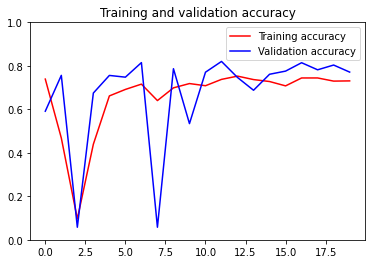

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss= history.history['loss']
epochs = range(len(loss))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.ylim(ymax=1,ymin=0)

plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.layers import Embedding

model = Sequential()
model.add(layers.Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(layers.GRU(64,dropout=0.2,recurrent_dropout=0.2))
model.add(layers.Dense(1))

# we are adding our pretrained weights from glove here. 
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))
keras.backend.clear_session()
del model

Epoch 1/20
6988/6988 [==============================] - 764s 109ms/step - loss: 0.0859 - accuracy: 0.7124 - val_loss: -0.4642 - val_accuracy: 0.7698
Epoch 2/20
6988/6988 [==============================] - 746s 107ms/step - loss: -0.4132 - accuracy: 0.7543 - val_loss: -0.6927 - val_accuracy: 0.7478
Epoch 3/20
6988/6988 [==============================] - 747s 107ms/step - loss: -0.5750 - accuracy: 0.7694 - val_loss: -0.7729 - val_accuracy: 0.7855
Epoch 4/20
6988/6988 [==============================] - 747s 107ms/step - loss: -0.6447 - accuracy: 0.7760 - val_loss: -0.7840 - val_accuracy: 0.8002
Epoch 5/20
2322/6988 [========>.....................] - ETA: 8:12 - loss: -0.7264 - accuracy: 0.7791